# Uses treecorr to compute w(theta) of galaxies around skewers

In [1]:
# First some imports that we'll use below
from __future__ import print_function
import treecorr
#import fitsio
from astropy.io import fits
import numpy
import time
import pprint
import healpy as hp

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

In [3]:
zbin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
#zbin

### Sanity check: NNCorr 

In [3]:
# let's try to grab data from some pixels on some low nside pixels:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results/"
fname = root + f"out_srcs_s2_5.fits"
f=fits.open(fname)

In [4]:
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =             55776447 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'TYPE    '           / label for field   1                            
TFORM1  = '1J      '           / data format of field: 4-byte INTEGER           
TUNIT1  = 'NA      '           / physical unit of field                         
TTYPE2  = 'RA      '           / label for field   2                            
TFORM2  = '1E      '        

5577645


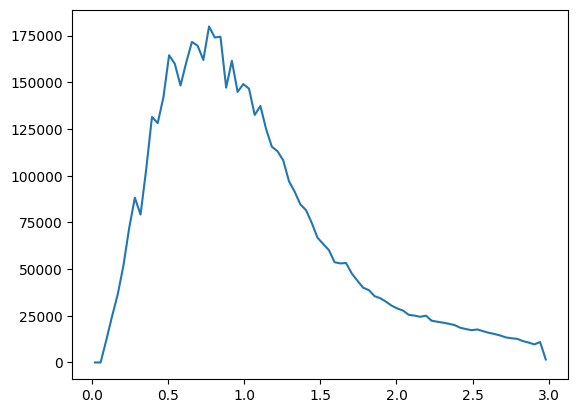

In [5]:
nside=8
npix = hp.nside2npix(nside)

ra_cat = f[1].data['RA'][::10]
dec_cat = f[1].data['DEC'][::10]
redshift_cat= f[1].data['Z_COSMO'][::10]
# show map:
pix_cat = hp.ang2pix(nside,
                 np.radians(90 - dec_cat),
                 np.radians(ra_cat))
unique_pix_nside8 = np.unique(pix_cat)

n = np.bincount(pix_cat, minlength=npix)

cc = np.histogram(redshift_cat, bins=80, range=[0,3])

print(len(pix_cat))

zb=(cc[1][1:]+cc[1][:-1])/2.
plt.plot(zb, cc[0])

[229 230 245 261 277 293 481 497 513 711 722 731 739]
261


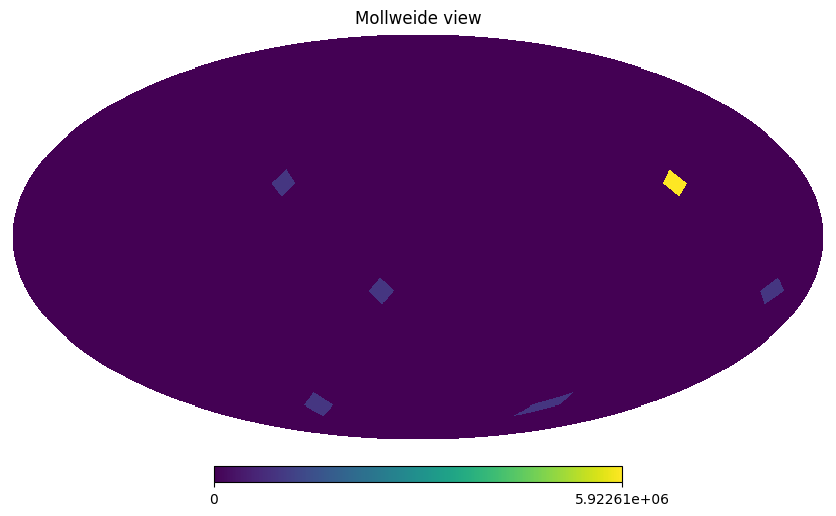

In [6]:
#hp.mollview(n)
usepix = unique_pix_nside8[3]
print(np.where(n>0)[0])
usen = np.zeros(len(n))
usen[usepix]=5e6
hp.mollview(n+usen)
print(usepix)

In [7]:
resol = hp.nside2resol(8)
resol *= 180/np.pi*60
print(resol)

439.7422607126279


In [8]:
# let's use one pixel for the test:
print(len(unique_pix_nside8))
usepix = unique_pix_nside8[3]

# make ra_cat, dec_cat inside these pixels:
inmask = np.isin(pix_cat, usepix)
red_sel = (redshift_cat>1.8)
ra_cat_mask = ra_cat[inmask*red_sel]
dec_cat_mask = dec_cat[inmask*red_sel]

print(len(ra_cat_mask))

13
108766


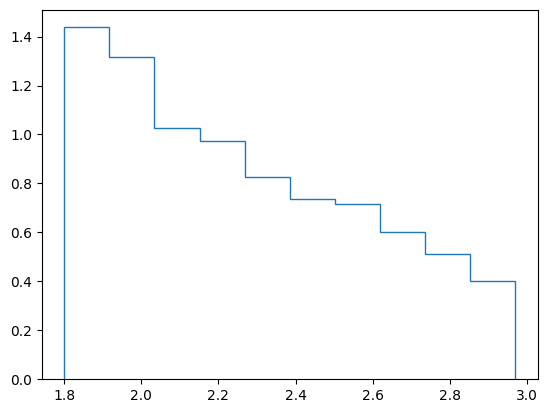

In [9]:
redshift_cat_mask = redshift_cat[inmask*red_sel]
cc=plt.hist(redshift_cat_mask,histtype='step',density=True)

In [10]:
# define the dataset:
#file_name = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results/out_srcs_s2_5.fits"
cat = treecorr.Catalog(ra=ra_cat_mask, dec=dec_cat_mask, ra_units='deg', dec_units='deg')

In [11]:
# make random catalogue
ra_min = numpy.min(cat.ra)
ra_max = numpy.max(cat.ra)
dec_min = numpy.min(cat.dec)
dec_max = numpy.max(cat.dec)
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

nside=8
for ii in range(5):
    tmp_ra = numpy.random.uniform(ra_min, ra_max, 10**6)
    tmp_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), 10**6)
    tmp_dec = numpy.arcsin(tmp_sindec)

    # select inside the pixel:
    pix_rand = hp.ang2pix(nside,
                     np.radians(90 - tmp_dec*180/np.pi),
                     np.radians(tmp_ra*180/np.pi))
    sel = np.isin(pix_rand, usepix)
    
    if ii==0:
        rand_ra = tmp_ra[sel]*180/np.pi
        rand_dec =tmp_dec[sel]*180/np.pi
        
    else:
        rand_ra = np.append(rand_ra, tmp_ra[sel]*180/np.pi)
        rand_dec = np.append(rand_dec, tmp_dec[sel]*180/np.pi)
print(len(rand_ra))

ra range = 4.123657 .. 4.319425
dec range = 0.253012 .. 0.429454
2516374


In [12]:
rand = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='deg', dec_units='deg')

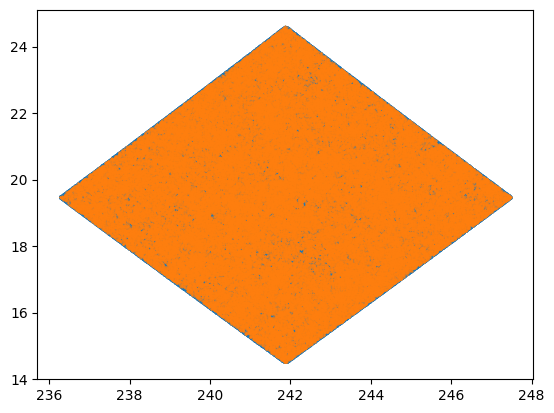

In [13]:
plt.scatter(rand_ra, rand_dec,s=0.2)
plt.scatter(ra_cat_mask, dec_cat_mask,s=0.2)

In [122]:
# Check NN correlation just to see if things makes sense:
nn = treecorr.NNCorrelation(min_sep=1, max_sep=100, nbins=10, sep_units='arcmin')
nn.process(cat)

In [123]:
rr = treecorr.NNCorrelation(min_sep=1, max_sep=100, nbins=10, sep_units='arcmin')
rr.process(rand)

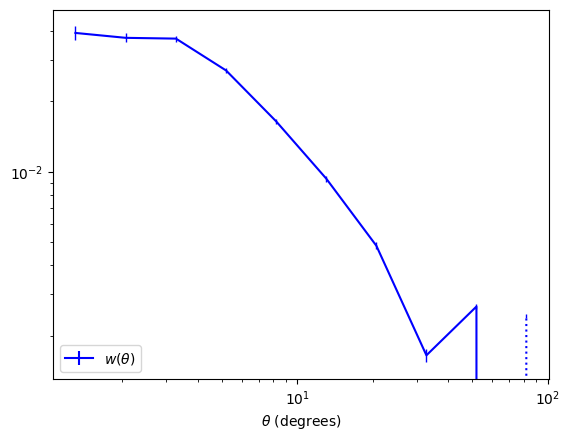

In [124]:
xi, varxi = nn.calculateXi(rr=rr)

r = numpy.exp(nn.meanlogr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
#plt.xlim([0.01,10])
plt.show()

In [107]:
# make this parallel so we can run on full sky etc.
saveroot = "/pscratch/sd/q/qhang/desi-lya/delta_F/"
pixel_list = np.loadtxt(saveroot + "pixel_list-nside-8.txt")

In [108]:
# let's try to grab data from some pixels on some low nside pixels:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results/"
nside=8
npix = hp.nside2npix(nside)

# let's register number of objects per pixel and unique pixel number:
Indpix = []
Nobj = []
zcut=[1.8,3.1]
for ii in range(128):
    fname = root + f"out_srcs_s2_{ii}.fits"
    f=fits.open(fname)
    
    redshift_cat= f[1].data['Z_COSMO']
    sel = (redshift_cat>zcut[0])&(redshift_cat<zcut[1])
    
    ra_cat = f[1].data['RA'][sel]
    dec_cat = f[1].data['DEC'][sel]
    # show map:
    pix_cat = hp.ang2pix(nside,
                     np.radians(90 - dec_cat),
                     np.radians(ra_cat))
    
    uniq_pix = np.unique(pix_cat)
    use = np.intersect1d(uniq_pix, pixel_list)
    
    if len(use) >0:
        for pixel in use:
            Indpix.append(pixel)
            ind = pix_cat == pixel
            Nobj.append(len(pix_cat[ind]))

664


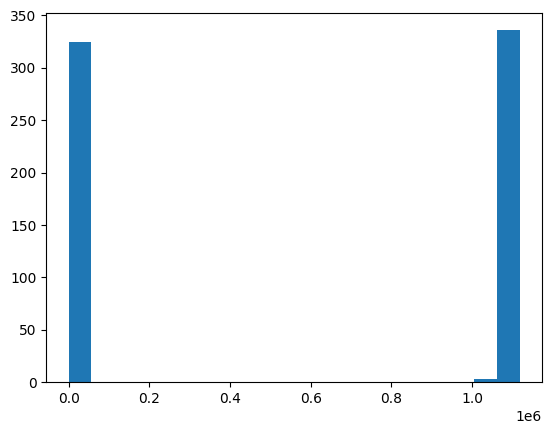

In [109]:
print(len(Indpix))

cc=plt.hist(np.array(Nobj), bins=20)

In [111]:
print(len(pixel_list))

339


# measure w_theta in overlapping area

In [4]:
# load the catalogues:

galaxy = fits.open("/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap.fits")

redshift = galaxy[1].data['Z_COSMO']+galaxy[1].data['DZ_RSD']
sel = redshift > 1.8
print(len(redshift[sel]))

cat = treecorr.Catalog(ra=galaxy[1].data['RA'][sel], 
                       dec=galaxy[1].data['DEC'][sel], 
                       ra_units='deg', dec_units='deg')

110938487


In [79]:
# delta f, in same mask:
mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
pixel_inmask = np.arange(len(mask))[mask.astype(bool)]

fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F/comb_pixgroup.fits")

ra = fin[1].data['RA']
dec = fin[1].data['DEC']
zbin = fin[1].data['Z_BIN']

deltaF_holder = {}
#totdF = np.zeros((17,2))
mean_dF=np.zeros(17)
    
nside=128
pix = hp.ang2pix(nside,
             np.radians(90 - dec),
             np.radians(ra))
sel = np.isin(pix, pixel_inmask)

for tomo in range(1,18):
    
    sel2 = np.isin(zbin[sel], np.array([tomo]))
    
    mean_dF[tomo-1] = np.sum(fin[1].data['DELTA_F'][sel][sel2])/len(fin[1].data['DELTA_F'][sel][sel2])
    
    deltaF = treecorr.Catalog(ra=ra[sel][sel2], dec=dec[sel][sel2],
                              ra_units='deg', dec_units='deg', 
                              k=fin[1].data['DELTA_F'][sel][sel2]-mean_dF[tomo-1])
    
    deltaF_holder[tomo] = deltaF

In [23]:
for tomo in range(1,18):
    print(totdF[tomo-1,0]/totdF[tomo-1,1])

-0.0003416538698614028
0.00022831358930320333
-0.00036057175220271186
0.0008227513964944062
0.0007434841979360831
-0.00011810086687411444
0.00014374709371770913
-0.00042476329850595854
0.0003156025760129681
-0.00026233627658802473
-1.0542625256187918e-05
0.0006596639140488699
-0.0008789135399206417
-0.0009343570034031194
2.034173134861426e-05
0.0004584707656031599
-0.002037810462802673


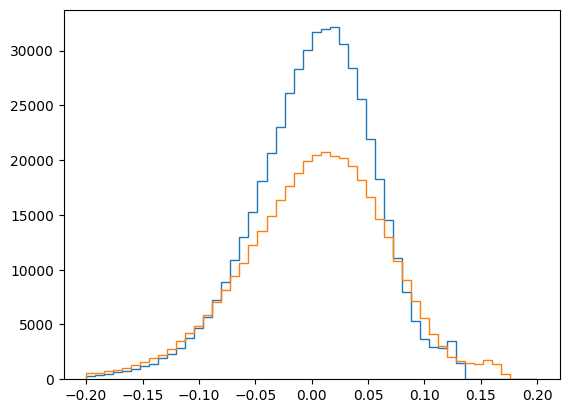

In [85]:
cc = plt.hist(deltaF_holder[1].k,bins=50,range=[-0.2,0.2],histtype='step')
cc=plt.hist(deltaF_holder[5].k,bins=50,range=[-0.2,0.2],histtype='step')

In [24]:
# okay if we don't need to combine, we just compute nk then subtract the mean:

# do this for each tomo bin, save
corr_func_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/w_theta/"

nk = treecorr.NKCorrelation(min_sep=1, max_sep=20, nbins=10, sep_units='arcmin')
for tomo in range(1,18):
    deltaF = deltaF_holder[tomo]
    nk.process(cat, deltaF)
    
    r = np.exp(nk.meanlogr)
    rawxi = nk.raw_xi
    rawsig = nk.raw_varxi
    # so there is a constant to subtract!
    #mean_F = totdF[tomo-1,0]/totdF[tomo-1,1]
    
    corr_func_holder[tomo] = np.c_[r, rawxi, np.sqrt(rawsig)]
    
    fname = root + f"w_theta-tomo-{tomo}.txt"
    np.savetxt(fname, corr_func_holder[tomo])

In [25]:
# measure auto-correlation:
# do this for each tomo bin, save
corr_func_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/w_theta/"

kk = treecorr.KKCorrelation(min_sep=1, max_sep=20, nbins=10, sep_units='arcmin')
for tomo in deltaF_holder.keys():
    deltaF = deltaF_holder[tomo]
    kk.process(deltaF)
    
    r = np.exp(kk.meanlogr)
    rawxi = kk.xi
    rawsig = kk.varxi
    
    corr_func_holder[tomo] = np.c_[r, rawxi, np.sqrt(rawsig)]
    
    fname = root + f"w_theta-lyalya-tomo-{tomo}.txt"
    np.savetxt(fname, corr_func_holder[tomo])

In [5]:
# load r, corr_func:
xcorr_func_holder={}
acorr_func_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/w_theta/"

for tomo in range(1,18):
    fname = root + f"w_theta-tomo-{tomo}.txt"
    xcorr_func_holder[tomo] = np.loadtxt(fname)
    
    fname = root + f"w_theta-lyalya-tomo-{tomo}.txt"
    acorr_func_holder[tomo] = np.loadtxt(fname)
    
r = xcorr_func_holder[tomo][:,0]

In [6]:
zsampf = np.loadtxt('/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt')
#print(zsamp.shape)
zsamp = zsampf[:-1,1]

Text(0.5, 1.0, 'Lya - galaxy Cross-correlation')

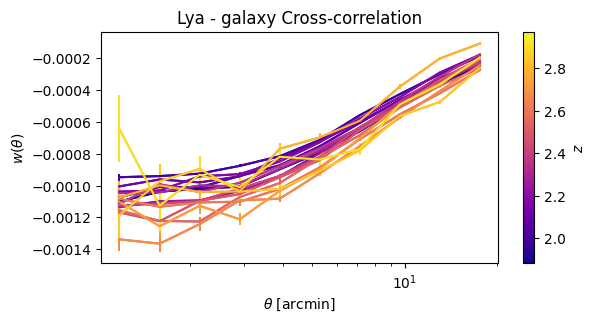

In [7]:
cmap = plt.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(6.4, 3))

from matplotlib.collections import LineCollection
line_collection = LineCollection([np.c_[r, xcorr_func_holder[tomo][:,1]] for tomo in range(1,18)], 
                                 array=zsamp, cmap=cmap)

for tomo in range(1,18):
    r = xcorr_func_holder[tomo][:,0]
    w = xcorr_func_holder[tomo][:,1]
    yerr=xcorr_func_holder[tomo][:,2]
    plt.errorbar(r, w, yerr=yerr, color=cmap(tomo/18))

ax.add_collection(line_collection)

plt.colorbar(line_collection,label='$z$')
    
plt.xscale('log')
plt.ylabel("$w(\\theta)$")
plt.xlabel("$\\theta$ [arcmin]")
plt.title("Lya - galaxy Cross-correlation")

Text(0.5, 1.0, 'Lya - Lya Auto-correlation')

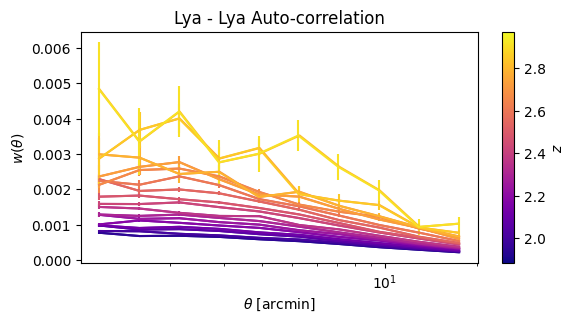

In [8]:
cmap = plt.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(6.4, 3))

from matplotlib.collections import LineCollection
line_collection = LineCollection([np.c_[r, acorr_func_holder[tomo][:,1]] for tomo in range(1,18)], 
                                 array=zsamp, cmap=cmap)

for tomo in range(1,18):
    r = acorr_func_holder[tomo][:,0]
    w = acorr_func_holder[tomo][:,1]
    yerr=acorr_func_holder[tomo][:,2]
    plt.errorbar(r, w, yerr=yerr, color=cmap(tomo/18))

ax.add_collection(line_collection)

plt.colorbar(line_collection,label='$z$')
    
plt.xscale('log')
plt.ylabel("$w(\\theta)$")
plt.xlabel("$\\theta$ [arcmin]")
plt.title("Lya - Lya Auto-correlation")

In [9]:
# compute weighted average of these measurements:

weight = r**(-1)

# bias mitigation: here we know the true bias, scale it out simply:
xwp_measure = np.zeros(17)
xwp_measure_err = np.zeros(17)

awp_measure = np.zeros(17)
awp_measure_err = np.zeros(17)

for tomo in range(1,18):
    xwp_measure[tomo-1] = np.sum(weight*xcorr_func_holder[tomo][:,1])/np.sum(weight)
    sqerr = (xcorr_func_holder[tomo][:,2]/xcorr_func_holder[tomo][:,1])**2
    xwp_measure_err[tomo-1] = np.sqrt(np.sum(sqerr*weight)/np.sum(weight))*abs(xwp_measure[tomo-1])
    
    awp_measure[tomo-1] = np.sum(weight*acorr_func_holder[tomo][:,1])/np.sum(weight)
    sqerr = (acorr_func_holder[tomo][:,2]/acorr_func_holder[tomo][:,1])**2
    awp_measure_err[tomo-1] = np.sqrt(np.sum(sqerr*weight)/np.sum(weight))*abs(awp_measure[tomo-1])

In [10]:
# load bias evolution:
bias_z = np.loadtxt("bias_dc2.txt")

bias_z_int = np.interp(zsamp, bias_z[:,0], bias_z[:,1])

#bias_z_lya = (1+zsamp)**3

In [11]:
galaxy = fits.open("/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap.fits")

redshift = galaxy[1].data['Z_COSMO']+galaxy[1].data['DZ_RSD']

cc = np.histogram(redshift[redshift > 1.8], bins=zsampf[:,0])
nz = cc[0]/np.sum(cc[0])/(cc[1][1]-cc[1][0])

Text(0, 0.5, '$n(z)$')

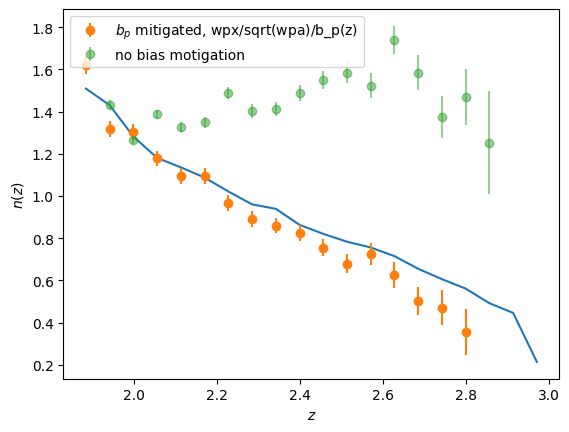

In [12]:
#plt.plot(zsamp[:17], abs(wp_measure), 's')
factor = 1e2
plt.plot(zsamp, nz)
combin_error = abs(xwp_measure_err/xwp_measure) + 0.5*abs(awp_measure_err/awp_measure)
y = abs(xwp_measure/bias_z_int[1:18]/np.sqrt(awp_measure))
yerr= abs(y*combin_error)
#yerr=xwp_measure_err/bias_z_int[:17]/np.sqrt(awp_measure)
plt.errorbar(zsamp[:17], y*factor , 
             yerr = yerr*factor, 
             fmt='o', label='$b_p$ mitigated, wpx/sqrt(wpa)/b_p(z)')

# plot no correction version:
factor = 1.5e3
plt.errorbar(zsamp[1:18], abs(xwp_measure)*factor , 
             yerr = (xwp_measure_err)*factor, fmt='o',alpha=0.5, label='no bias motigation')

plt.legend(loc='upper left')

plt.xlabel("$z$")
plt.ylabel("$n(z)$")
#plt.text(2.0,6,'$n(z) \\propto \\frac{\\sum \\theta ^{-1} w(\\theta, z)}{\\sum \\theta ^{-1}} \\times\\frac{1}{b_p(z)}$')

# measure w_theta in overlapping area - delta from Laura

In [49]:
# delta f, in same mask:
mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
pixel_inmask = np.arange(len(mask))[mask.astype(bool)]

fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F/delta-laura-comb.fits")

ra = fin[1].data['RA']
dec = fin[1].data['DEC']
zbin = fin[1].data['Z_BIN']

ra = ra*180/np.pi
dec = dec*180/np.pi

deltaF_holder = {}
#totdF = np.zeros((20,2))
mean_dF = np.zeros(20)
    
nside=128
pix = hp.ang2pix(nside,
             np.radians(90 - dec),
             np.radians(ra))
sel = np.isin(pix, pixel_inmask)

for tomo in range(1,21):
    
    sel2 = np.isin(zbin[sel], np.array([tomo]))
    
    if len(ra[sel][sel2])>0:
    
        mean_dF[tomo-1] = np.sum(fin[1].data['DELTA_F'][sel][sel2])/len(fin[1].data['DELTA_F'][sel][sel2])
        deltaF = treecorr.Catalog(ra=ra[sel][sel2], dec=dec[sel][sel2],
                              ra_units='deg', dec_units='deg', 
                              k=fin[1].data['DELTA_F'][sel][sel2]-mean_dF[tomo-1])
        
        deltaF_holder[tomo] = deltaF

In [51]:
print(mean_dF)

[ 0.          0.00024252  0.00035199 -0.00048383  0.00022727  0.00058364
  0.00010043  0.00049815 -0.00020004  0.00037183 -0.00076686 -0.00037688
  0.00068699 -0.0006843  -0.00034158  0.00113882  0.00095281 -0.0012615
 -0.0021687   0.01370992]


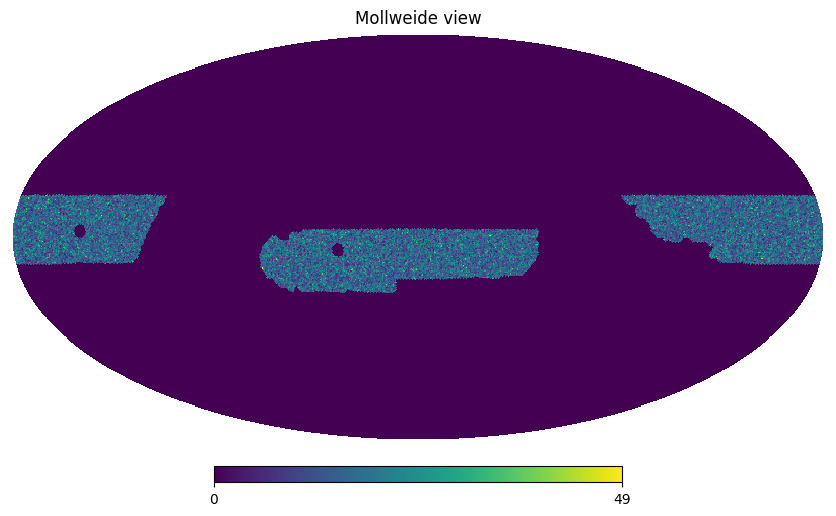

In [64]:
ra = (deltaF_holder[2].ra)*180/np.pi
dec = (deltaF_holder[2].dec)*180/np.pi
# look at healpix map:
nside = 128
npix = int(12*nside**2)
pix = hp.ang2pix(nside,
                     np.radians(90 - dec),
                     np.radians(ra))
n = np.bincount(pix, minlength=npix)
hp.mollview(n)

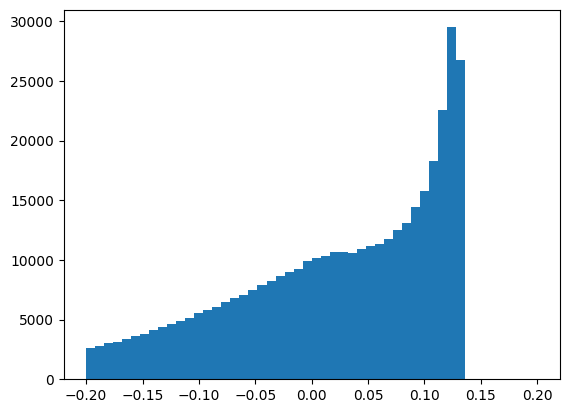

In [72]:
cc=plt.hist(deltaF_holder[2].k,bins=50,range=[-0.2,0.2])

In [52]:
# okay if we don't need to combine, we just compute nk then subtract the mean:
# do this for each tomo bin, save
corr_func_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/w_theta/"

nk = treecorr.NKCorrelation(min_sep=1, max_sep=20, nbins=10, sep_units='arcmin')
for tomo in deltaF_holder.keys():
    deltaF = deltaF_holder[tomo]
    nk.process(cat, deltaF)
    
    r = np.exp(nk.meanlogr)
    rawxi = nk.raw_xi
    rawsig = nk.raw_varxi
    # so there is a constant to subtract!
    corr_func_holder[tomo] = np.c_[r, rawxi, np.sqrt(rawsig)]

    fname = root + f"w_theta-laura-tomo-{tomo}.txt"
    np.savetxt(fname, corr_func_holder[tomo])

In [53]:
# measure Lya auto correlation:

# do this for each tomo bin, save
corr_func_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/w_theta/"

kk = treecorr.KKCorrelation(min_sep=1, max_sep=20, nbins=10, sep_units='arcmin')
for tomo in deltaF_holder.keys():
    deltaF = deltaF_holder[tomo]
    kk.process(deltaF)
    
    r = np.exp(kk.meanlogr)
    rawxi = kk.xi
    rawsig = kk.varxi

    corr_func_holder[tomo] = np.c_[r, rawxi, np.sqrt(rawsig)]
    
    fname = root + f"w_theta-lyalya-laura-tomo-{tomo}.txt"
    np.savetxt(fname, corr_func_holder[tomo])

In [54]:
# load r, corr_func:
xcorr_func_holder={}
acorr_func_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/w_theta/"

for tomo in range(2,21):
    fname = root + f"w_theta-laura-tomo-{tomo}.txt"
    xcorr_func_holder[tomo] = np.loadtxt(fname)
    
    fname = root + f"w_theta-lyalya-laura-tomo-{tomo}.txt"
    acorr_func_holder[tomo] = np.loadtxt(fname)
    
r = xcorr_func_holder[tomo][:,0]

(-0.002, 0.0)

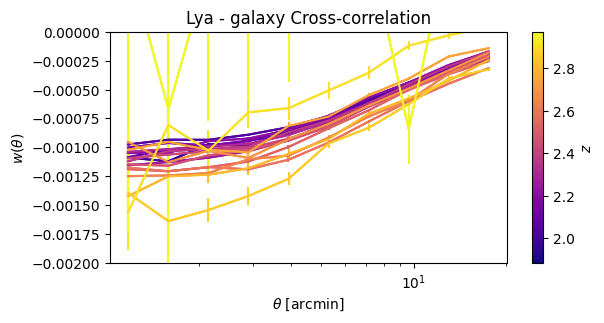

In [56]:
# now let's see the results:
cmap = plt.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(6.4, 3))

from matplotlib.collections import LineCollection
line_collection = LineCollection([np.c_[r, xcorr_func_holder[tomo][:,1]] for tomo in xcorr_func_holder.keys()], 
                                 array=zsamp, cmap=cmap)

for tomo in xcorr_func_holder.keys():
    r = xcorr_func_holder[tomo][:,0]
    w = xcorr_func_holder[tomo][:,1]
    yerr=xcorr_func_holder[tomo][:,2]
    plt.errorbar(r, w, yerr=yerr, color=cmap(tomo/20))

ax.add_collection(line_collection)

plt.colorbar(line_collection,label='$z$')
#plt.ylim([-1e-3,1e-3])
    
plt.xscale('log')
plt.ylabel("$w(\\theta)$")
plt.xlabel("$\\theta$ [arcmin]")
plt.title("Lya - galaxy Cross-correlation")
plt.ylim([-0.002,0])

(0.0, 0.007)

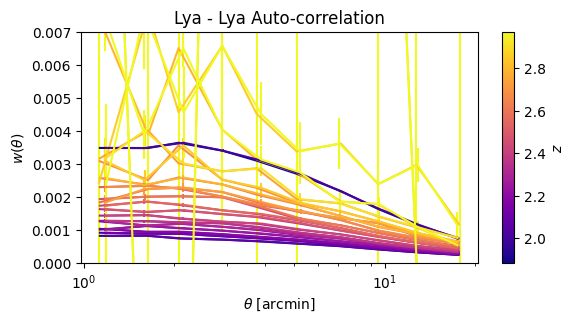

In [60]:
cmap = plt.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(6.4, 3))

from matplotlib.collections import LineCollection
line_collection = LineCollection([np.c_[r, acorr_func_holder[tomo][:,1]] for tomo in acorr_func_holder.keys()], 
                                 array=zsamp, cmap=cmap)

for tomo in acorr_func_holder.keys():
    r = acorr_func_holder[tomo][:,0]
    w = acorr_func_holder[tomo][:,1]
    yerr=acorr_func_holder[tomo][:,2]
    plt.errorbar(r, w, yerr=yerr, color=cmap(tomo/18))

ax.add_collection(line_collection)

plt.colorbar(line_collection,label='$z$')
    
plt.xscale('log')
plt.ylabel("$w(\\theta)$")
plt.xlabel("$\\theta$ [arcmin]")
plt.title("Lya - Lya Auto-correlation")
plt.ylim([0,0.007])

In [75]:
# compute weighted average of these measurements:

weight = r**(-1)

# bias mitigation: here we know the true bias, scale it out simply:
xwp_measure = np.zeros(20)
xwp_measure_err = np.zeros(20)

awp_measure = np.zeros(20)
awp_measure_err = np.zeros(20)

for tomo in range(2,21):
    xwp_measure[tomo-1] = np.sum(weight*xcorr_func_holder[tomo][:,1])/np.sum(weight)
    sqerr = (xcorr_func_holder[tomo][:,2]/xcorr_func_holder[tomo][:,1])**2
    xwp_measure_err[tomo-1] = np.sqrt(np.sum(sqerr*weight)/np.sum(weight))*abs(xwp_measure[tomo-1])
    
    awp_measure[tomo-1] = np.sum(weight*acorr_func_holder[tomo][:,1])/np.sum(weight)
    sqerr = (acorr_func_holder[tomo][:,2]/acorr_func_holder[tomo][:,1])**2
    awp_measure_err[tomo-1] = np.sqrt(np.sum(sqerr*weight)/np.sum(weight))*abs(awp_measure[tomo-1])

Text(0.5, 1.0, 'Using pre-computed delta')

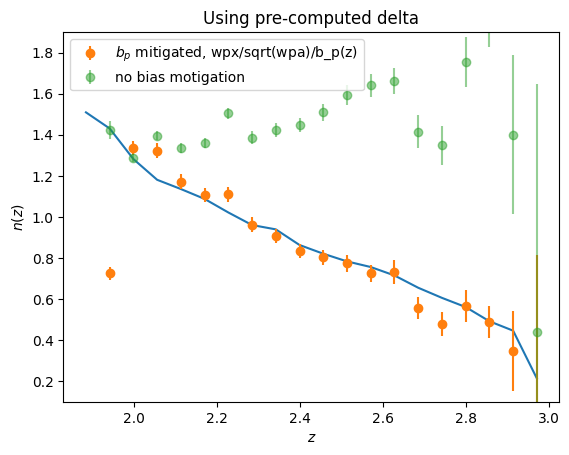

In [90]:
#plt.plot(zsamp[:17], abs(wp_measure), 's')
factor = 1e2
plt.plot(zsamp, nz)
combin_error = abs(xwp_measure_err[1:]/xwp_measure[1:]) + 0.5*abs(awp_measure_err[1:]/awp_measure[1:])
y = abs(xwp_measure[1:]/bias_z_int[1:]/np.sqrt(awp_measure[1:]))
yerr= abs(y*combin_error)
#yerr=xwp_measure_err/bias_z_int[:17]/np.sqrt(awp_measure)
plt.errorbar(zsamp[1:], y*factor , 
             yerr = yerr*factor, 
             fmt='o', label='$b_p$ mitigated, wpx/sqrt(wpa)/b_p(z)')

# plot no correction version:
factor = 1.5e3
plt.errorbar(zsamp[1:], abs(xwp_measure[1:])*factor , 
             yerr = (xwp_measure_err[1:])*factor, fmt='o',alpha=0.5, label='no bias motigation')

plt.legend(loc='upper left')

plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.ylim([0.1,1.9])
plt.title("Using pre-computed delta")
#plt.text(2.0,6,'$n(z) \\propto \\frac{\\sum \\theta ^{-1} w(\\theta, z)}{\\sum \\theta ^{-1}} \\times\\frac{1}{b_p(z)}$')